In [3]:
pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
print(sys.executable)
print(sys.version)
import torch
from torch.utils.data import DataLoader

/bin/python3
3.8.10 (default, Nov 22 2023, 10:22:35) 
[GCC 9.4.0]


In [2]:

from typing import Union, Optional, Callable, Tuple
from pathlib import Path
import os
import pickle
import logging
import random
import h5py
import numpy as np


In [4]:
class SliceDataset(torch.utils.data.Dataset):
    """
    A PyTorch Dataset that provides access to MR image slices.
    """

    def __init__(
        self,
        root: Union[str, Path, os.PathLike],
        challenge: str,
        transform: Optional[Callable] = None,
        use_dataset_cache: bool = False,
        sample_rate: Optional[float] = None,
        volume_sample_rate: Optional[float] = None,
        dataset_cache_file: Union[str, Path, os.PathLike] = "dataset_cache.pkl",
        num_cols: Optional[Tuple[int]] = None,
        raw_sample_filter: Optional[Callable] = None,
    ):
        """
        Args:
            root: Path to the dataset.
            challenge: "singlecoil" or "multicoil" depending on which challenge
                to use.
            transform: Optional; A callable object that pre-processes the raw
                data into appropriate form. The transform function should take
                'kspace', 'target', 'attributes', 'filename', and 'slice' as
                inputs. 'target' may be null for test data.
            use_dataset_cache: Whether to cache dataset metadata. This is very
                useful for large datasets like the brain data.
            sample_rate: Optional; A float between 0 and 1. This controls what fraction
                of the slices should be loaded. Defaults to 1 if no value is given.
                When creating a sampled dataset either set sample_rate (sample by slices)
                or volume_sample_rate (sample by volumes) but not both.
            volume_sample_rate: Optional; A float between 0 and 1. This controls what fraction
                of the volumes should be loaded. Defaults to 1 if no value is given.
                When creating a sampled dataset either set sample_rate (sample by slices)
                or volume_sample_rate (sample by volumes) but not both.
            dataset_cache_file: Optional; A file in which to cache dataset
                information for faster load times.
            num_cols: Optional; If provided, only slices with the desired
                number of columns will be considered.
            raw_sample_filter: Optional; A callable object that takes an raw_sample
                metadata as input and returns a boolean indicating whether the
                raw_sample should be included in the dataset.
        """
        if challenge not in ("singlecoil", "multicoil"):
            raise ValueError('challenge should be either "singlecoil" or "multicoil"')

        if sample_rate is not None and volume_sample_rate is not None:
            raise ValueError(
                "either set sample_rate (sample by slices) or volume_sample_rate (sample by volumes) but not both"
            )

        self.dataset_cache_file = Path(dataset_cache_file)

        self.transform = transform
        self.recons_key = (
            "reconstruction_esc" if challenge == "singlecoil" else "reconstruction_rss"
        )
        self.raw_samples = []
        if raw_sample_filter is None:
            self.raw_sample_filter = lambda raw_sample: True
        else:
            self.raw_sample_filter = raw_sample_filter

        # set default sampling mode if none given
        if sample_rate is None:
            sample_rate = 1.0
        if volume_sample_rate is None:
            volume_sample_rate = 1.0

        # load dataset cache if we have and user wants to use it
        if self.dataset_cache_file.exists() and use_dataset_cache:
            with open(self.dataset_cache_file, "rb") as f:
                dataset_cache = pickle.load(f)
        else:
            dataset_cache = {}

        # check if our dataset is in the cache
        # if there, use that metadata, if not, then regenerate the metadata
        if dataset_cache.get(root) is None or not use_dataset_cache:
            files = list(Path(root).iterdir())
            for fname in sorted(files):
                metadata, num_slices = self._retrieve_metadata(fname)

                new_raw_samples = []
                for slice_ind in range(num_slices):
                    raw_sample = FastMRIRawDataSample(fname, slice_ind, metadata)
                    if self.raw_sample_filter(raw_sample):
                        new_raw_samples.append(raw_sample)

                self.raw_samples += new_raw_samples

            if dataset_cache.get(root) is None and use_dataset_cache:
                dataset_cache[root] = self.raw_samples
                logging.info(f"Saving dataset cache to {self.dataset_cache_file}.")
                with open(self.dataset_cache_file, "wb") as cache_f:
                    pickle.dump(dataset_cache, cache_f)
        else:
            logging.info(f"Using dataset cache from {self.dataset_cache_file}.")
            self.raw_samples = dataset_cache[root]

        # subsample if desired
        if sample_rate < 1.0:  # sample by slice
            random.shuffle(self.raw_samples)
            num_raw_samples = round(len(self.raw_samples) * sample_rate)
            self.raw_samples = self.raw_samples[:num_raw_samples]
        elif volume_sample_rate < 1.0:  # sample by volume
            vol_names = sorted(list(set([f[0].stem for f in self.raw_samples])))
            random.shuffle(vol_names)
            num_volumes = round(len(vol_names) * volume_sample_rate)
            sampled_vols = vol_names[:num_volumes]
            self.raw_samples = [
                raw_sample
                for raw_sample in self.raw_samples
                if raw_sample[0].stem in sampled_vols
            ]

        if num_cols:
            self.raw_samples = [
                ex
                for ex in self.raw_samples
                if ex[2]["encoding_size"][1] in num_cols  # type: ignore
            ]

    def _retrieve_metadata(self, fname):
        with h5py.File(fname, "r") as hf:
            et_root = etree.fromstring(hf["ismrmrd_header"][()])

            enc = ["encoding", "encodedSpace", "matrixSize"]
            enc_size = (
                int(et_query(et_root, enc + ["x"])),
                int(et_query(et_root, enc + ["y"])),
                int(et_query(et_root, enc + ["z"])),
            )
            rec = ["encoding", "reconSpace", "matrixSize"]
            recon_size = (
                int(et_query(et_root, rec + ["x"])),
                int(et_query(et_root, rec + ["y"])),
                int(et_query(et_root, rec + ["z"])),
            )

            lims = ["encoding", "encodingLimits", "kspace_encoding_step_1"]
            enc_limits_center = int(et_query(et_root, lims + ["center"]))
            enc_limits_max = int(et_query(et_root, lims + ["maximum"])) + 1

            padding_left = enc_size[1] // 2 - enc_limits_center
            padding_right = padding_left + enc_limits_max

            num_slices = hf["kspace"].shape[0]

            metadata = {
                "padding_left": padding_left,
                "padding_right": padding_right,
                "encoding_size": enc_size,
                "recon_size": recon_size,
                **hf.attrs,
            }

        return metadata, num_slices

    def __len__(self):
        return len(self.raw_samples)

    def __getitem__(self, i: int):
        fname, dataslice, metadata = self.raw_samples[i]

        with h5py.File(fname, "r") as hf:
            kspace = hf["kspace"][dataslice]

            mask = np.asarray(hf["mask"]) if "mask" in hf else None

            target = hf[self.recons_key][dataslice] if self.recons_key in hf else None

            attrs = dict(hf.attrs)
            attrs.update(metadata)

        if self.transform is None:
            sample = (kspace, mask, target, attrs, fname.name, dataslice)
        else:
            sample = self.transform(kspace, mask, target, attrs, fname.name, dataslice)

        return sample


Run either above one or below one both works

In [5]:
"""
Copyright (c) Facebook, Inc. and its affiliates.

This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.
"""

import logging
import os
import pickle
import random
import xml.etree.ElementTree as etree
from copy import deepcopy
from pathlib import Path
from typing import (
    Any,
    Callable,
    Dict,
    List,
    NamedTuple,
    Optional,
    Sequence,
    Tuple,
    Union,
)
from warnings import warn

import h5py
import numpy as np
import pandas as pd
import requests
import torch
import yaml
from tqdm import tqdm


def et_query(
    root: etree.Element,
    qlist: Sequence[str],
    namespace: str = "http://www.ismrm.org/ISMRMRD",
) -> str:
    """
    ElementTree query function.

    This can be used to query an xml document via ElementTree. It uses qlist
    for nested queries.

    Args:
        root: Root of the xml to search through.
        qlist: A list of strings for nested searches, e.g. ["Encoding",
            "matrixSize"]
        namespace: Optional; xml namespace to prepend query.

    Returns:
        The retrieved data as a string.
    """
    s = "."
    prefix = "ismrmrd_namespace"

    ns = {prefix: namespace}

    for el in qlist:
        s = s + f"//{prefix}:{el}"

    value = root.find(s, ns)
    if value is None:
        raise RuntimeError("Element not found")

    return str(value.text)


def fetch_dir(
    key: str, data_config_file: Union[str, Path, os.PathLike] = "fastmri_dirs.yaml"
) -> Path:
    """
    Data directory fetcher.

    This is a brute-force simple way to configure data directories for a
    project. Simply overwrite the variables for `knee_path` and `brain_path`
    and this function will retrieve the requested subsplit of the data for use.

    Args:
        key: key to retrieve path from data_config_file. Expected to be in
            ("knee_path", "brain_path", "log_path").
        data_config_file: Optional; Default path config file to fetch path
            from.

    Returns:
        The path to the specified directory.
    """
    data_config_file = Path(data_config_file)
    if not data_config_file.is_file():
        default_config = {
            "knee_path": "/path/to/knee",
            "brain_path": "/path/to/brain",
            "log_path": ".",
        }
        with open(data_config_file, "w") as f:
            yaml.dump(default_config, f)

        data_dir = default_config[key]

        warn(
            f"Path config at {data_config_file.resolve()} does not exist. "
            "A template has been created for you. "
            "Please enter the directory paths for your system to have defaults."
        )
    else:
        with open(data_config_file, "r") as f:
            data_dir = yaml.safe_load(f)[key]

    return Path(data_dir)


class FastMRIRawDataSample(NamedTuple):
    fname: Path
    slice_ind: int
    metadata: Dict[str, Any]


class CombinedSliceDataset(torch.utils.data.Dataset):
    """
    A container for combining slice datasets.
    """

    def __init__(
        self,
        roots: Sequence[Path],
        challenges: Sequence[str],
        transforms: Optional[Sequence[Optional[Callable]]] = None,
        sample_rates: Optional[Sequence[Optional[float]]] = None,
        volume_sample_rates: Optional[Sequence[Optional[float]]] = None,
        use_dataset_cache: bool = False,
        dataset_cache_file: Union[str, Path, os.PathLike] = "dataset_cache.pkl",
        num_cols: Optional[Tuple[int]] = None,
        raw_sample_filter: Optional[Callable] = None,
    ):
        """
        Args:
            roots: Paths to the datasets.
            challenges: "singlecoil" or "multicoil" depending on which
                challenge to use.
            transforms: Optional; A sequence of callable objects that
                preprocesses the raw data into appropriate form. The transform
                function should take 'kspace', 'target', 'attributes',
                'filename', and 'slice' as inputs. 'target' may be null for
                test data.
            sample_rates: Optional; A sequence of floats between 0 and 1.
                This controls what fraction of the slices should be loaded.
                When creating subsampled datasets either set sample_rates
                (sample by slices) or volume_sample_rates (sample by volumes)
                but not both.
            volume_sample_rates: Optional; A sequence of floats between 0 and 1.
                This controls what fraction of the volumes should be loaded.
                When creating subsampled datasets either set sample_rates
                (sample by slices) or volume_sample_rates (sample by volumes)
                but not both.
            use_dataset_cache: Whether to cache dataset metadata. This is very
                useful for large datasets like the brain data.
            dataset_cache_file: Optional; A file in which to cache dataset
                information for faster load times.
            num_cols: Optional; If provided, only slices with the desired
                number of columns will be considered.
            raw_sample_filter: Optional; A callable object that takes an raw_sample
                metadata as input and returns a boolean indicating whether the
                raw_sample should be included in the dataset.
        """
        if sample_rates is not None and volume_sample_rates is not None:
            raise ValueError(
                "either set sample_rates (sample by slices) or volume_sample_rates (sample by volumes) but not both"
            )
        if transforms is None:
            transforms = [None] * len(roots)
        if sample_rates is None:
            sample_rates = [None] * len(roots)
        if volume_sample_rates is None:
            volume_sample_rates = [None] * len(roots)
        if not (
            len(roots)
            == len(transforms)
            == len(challenges)
            == len(sample_rates)
            == len(volume_sample_rates)
        ):
            raise ValueError(
                "Lengths of roots, transforms, challenges, sample_rates do not match"
            )

        self.datasets = []
        self.raw_samples: List[FastMRIRawDataSample] = []
        for i in range(len(roots)):
            self.datasets.append(
                SliceDataset(
                    root=roots[i],
                    transform=transforms[i],
                    challenge=challenges[i],
                    sample_rate=sample_rates[i],
                    volume_sample_rate=volume_sample_rates[i],
                    use_dataset_cache=use_dataset_cache,
                    dataset_cache_file=dataset_cache_file,
                    num_cols=num_cols,
                    raw_sample_filter=raw_sample_filter,
                )
            )

            self.raw_samples = self.raw_samples + self.datasets[-1].raw_samples

    def __len__(self):
        return sum(len(dataset) for dataset in self.datasets)

    def __getitem__(self, i):
        for dataset in self.datasets:
            if i < len(dataset):
                return dataset[i]
            else:
                i = i - len(dataset)


class SliceDataset(torch.utils.data.Dataset):
    """
    A PyTorch Dataset that provides access to MR image slices.
    """

    def __init__(
        self,
        root: Union[str, Path, os.PathLike],
        challenge: str,
        transform: Optional[Callable] = None,
        use_dataset_cache: bool = False,
        sample_rate: Optional[float] = None,
        volume_sample_rate: Optional[float] = None,
        dataset_cache_file: Union[str, Path, os.PathLike] = "dataset_cache.pkl",
        num_cols: Optional[Tuple[int]] = None,
        raw_sample_filter: Optional[Callable] = None,
    ):
        """
        Args:
            root: Path to the dataset.
            challenge: "singlecoil" or "multicoil" depending on which challenge
                to use.
            transform: Optional; A callable object that pre-processes the raw
                data into appropriate form. The transform function should take
                'kspace', 'target', 'attributes', 'filename', and 'slice' as
                inputs. 'target' may be null for test data.
            use_dataset_cache: Whether to cache dataset metadata. This is very
                useful for large datasets like the brain data.
            sample_rate: Optional; A float between 0 and 1. This controls what fraction
                of the slices should be loaded. Defaults to 1 if no value is given.
                When creating a sampled dataset either set sample_rate (sample by slices)
                or volume_sample_rate (sample by volumes) but not both.
            volume_sample_rate: Optional; A float between 0 and 1. This controls what fraction
                of the volumes should be loaded. Defaults to 1 if no value is given.
                When creating a sampled dataset either set sample_rate (sample by slices)
                or volume_sample_rate (sample by volumes) but not both.
            dataset_cache_file: Optional; A file in which to cache dataset
                information for faster load times.
            num_cols: Optional; If provided, only slices with the desired
                number of columns will be considered.
            raw_sample_filter: Optional; A callable object that takes an raw_sample
                metadata as input and returns a boolean indicating whether the
                raw_sample should be included in the dataset.
        """
        if challenge not in ("singlecoil", "multicoil"):
            raise ValueError('challenge should be either "singlecoil" or "multicoil"')

        if sample_rate is not None and volume_sample_rate is not None:
            raise ValueError(
                "either set sample_rate (sample by slices) or volume_sample_rate (sample by volumes) but not both"
            )

        self.dataset_cache_file = Path(dataset_cache_file)

        self.transform = transform
        self.recons_key = (
            "reconstruction_esc" if challenge == "singlecoil" else "reconstruction_rss"
        )
        self.raw_samples = []
        if raw_sample_filter is None:
            self.raw_sample_filter = lambda raw_sample: True
        else:
            self.raw_sample_filter = raw_sample_filter

        # set default sampling mode if none given
        if sample_rate is None:
            sample_rate = 1.0
        if volume_sample_rate is None:
            volume_sample_rate = 1.0

        # load dataset cache if we have and user wants to use it
        if self.dataset_cache_file.exists() and use_dataset_cache:
            with open(self.dataset_cache_file, "rb") as f:
                dataset_cache = pickle.load(f)
        else:
            dataset_cache = {}

        # check if our dataset is in the cache
        # if there, use that metadata, if not, then regenerate the metadata
        if dataset_cache.get(root) is None or not use_dataset_cache:
            files = list(Path(root).iterdir())
            for fname in sorted(files):
                metadata, num_slices = self._retrieve_metadata(fname)

                new_raw_samples = []
                for slice_ind in range(num_slices):
                    raw_sample = FastMRIRawDataSample(fname, slice_ind, metadata)
                    if self.raw_sample_filter(raw_sample):
                        new_raw_samples.append(raw_sample)

                self.raw_samples += new_raw_samples

            if dataset_cache.get(root) is None and use_dataset_cache:
                dataset_cache[root] = self.raw_samples
                logging.info(f"Saving dataset cache to {self.dataset_cache_file}.")
                with open(self.dataset_cache_file, "wb") as cache_f:
                    pickle.dump(dataset_cache, cache_f)
        else:
            logging.info(f"Using dataset cache from {self.dataset_cache_file}.")
            self.raw_samples = dataset_cache[root]

        # subsample if desired
        if sample_rate < 1.0:  # sample by slice
            random.shuffle(self.raw_samples)
            num_raw_samples = round(len(self.raw_samples) * sample_rate)
            self.raw_samples = self.raw_samples[:num_raw_samples]
        elif volume_sample_rate < 1.0:  # sample by volume
            vol_names = sorted(list(set([f[0].stem for f in self.raw_samples])))
            random.shuffle(vol_names)
            num_volumes = round(len(vol_names) * volume_sample_rate)
            sampled_vols = vol_names[:num_volumes]
            self.raw_samples = [
                raw_sample
                for raw_sample in self.raw_samples
                if raw_sample[0].stem in sampled_vols
            ]

        if num_cols:
            self.raw_samples = [
                ex
                for ex in self.raw_samples
                if ex[2]["encoding_size"][1] in num_cols  # type: ignore
            ]

    def _retrieve_metadata(self, fname):
        with h5py.File(fname, "r") as hf:
            et_root = etree.fromstring(hf["ismrmrd_header"][()])

            enc = ["encoding", "encodedSpace", "matrixSize"]
            enc_size = (
                int(et_query(et_root, enc + ["x"])),
                int(et_query(et_root, enc + ["y"])),
                int(et_query(et_root, enc + ["z"])),
            )
            rec = ["encoding", "reconSpace", "matrixSize"]
            recon_size = (
                int(et_query(et_root, rec + ["x"])),
                int(et_query(et_root, rec + ["y"])),
                int(et_query(et_root, rec + ["z"])),
            )

            lims = ["encoding", "encodingLimits", "kspace_encoding_step_1"]
            enc_limits_center = int(et_query(et_root, lims + ["center"]))
            enc_limits_max = int(et_query(et_root, lims + ["maximum"])) + 1

            padding_left = enc_size[1] // 2 - enc_limits_center
            padding_right = padding_left + enc_limits_max

            num_slices = hf["kspace"].shape[0]

            metadata = {
                "padding_left": padding_left,
                "padding_right": padding_right,
                "encoding_size": enc_size,
                "recon_size": recon_size,
                **hf.attrs,
            }

        return metadata, num_slices

    def __len__(self):
        return len(self.raw_samples)

    def __getitem__(self, i: int):
        fname, dataslice, metadata = self.raw_samples[i]

        with h5py.File(fname, "r") as hf:
            kspace = hf["kspace"][dataslice]

            mask = np.asarray(hf["mask"]) if "mask" in hf else None

            target = hf[self.recons_key][dataslice] if self.recons_key in hf else None

            attrs = dict(hf.attrs)
            attrs.update(metadata)

        if self.transform is None:
            sample = (kspace, mask, target, attrs, fname.name, dataslice)
        else:
            sample = self.transform(kspace, mask, target, attrs, fname.name, dataslice)

        return sample


class AnnotatedSliceDataset(SliceDataset):
    """
    A PyTorch Dataset that provides access to MR image slices with annotation.

    This is a subclass from SliceDataset that incorporates functionality of the fastMRI+ dataset.
    It can be used to download the csv file from fastMRI+ based on the specified version using git hash.
    It parses the csv and links it to samples in SliceDataset as annotated_raw_samples.

    Github: https://github.com/microsoft/fastmri-plus
    Paper: https://arxiv.org/abs/2109.03812
    """

    def __init__(
        self,
        root: Union[str, Path, os.PathLike],
        challenge: str,
        subsplit: str,
        multiple_annotation_policy: str,
        transform: Optional[Callable] = None,
        use_dataset_cache: bool = False,
        sample_rate: Optional[float] = None,
        volume_sample_rate: Optional[float] = None,
        dataset_cache_file: Union[str, Path, os.PathLike] = "dataset_cache.pkl",
        num_cols: Optional[Tuple[int]] = None,
        annotation_version: Optional[str] = None,
    ):
        """
        Args:
            root: Path to the dataset.
            challenge: "singlecoil" or "multicoil" depending on which challenge
                to use.
            subsplit: 'knee' or 'brain' depending on which dataset to use.
            multiple_annotation_policy: 'first', 'random' or 'all'.
                If 'first', then only use the first annotation.
                If 'random', then pick an annotation at random.
                If 'all' then two or more copies of the same slice for each annotation
                will be extended.
            transform: Optional; A callable object that pre-processes the raw
                data into appropriate form. The transform function should take
                'kspace', 'target', 'attributes', 'filename', and 'slice' as
                inputs. 'target' may be null for test data.
            use_dataset_cache: Whether to cache dataset metadata. This is very
                useful for large datasets like the brain data.
            sample_rate: Optional; A float between 0 and 1. This controls what fraction
                of the slices should be loaded. Defaults to 1 if no value is given.
                When creating a sampled dataset either set sample_rate (sample by slices)
                or volume_sample_rate (sample by volumes) but not both.
            volume_sample_rate: Optional; A float between 0 and 1. This controls what fraction
                of the volumes should be loaded. Defaults to 1 if no value is given.
                When creating a sampled dataset either set sample_rate (sample by slices)
                or volume_sample_rate (sample by volumes) but not both.
            dataset_cache_file: Optional; A file in which to cache dataset
                information for faster load times.
            num_cols: Optional; If provided, only slices with the desired
                number of columns will be considered.
            annotation_version: Optional; If provided, a specific version of csv file will be downloaded based on its git hash.
                Default value is None, then the latest version will be used.
        """

        # subclass SliceDataset
        super().__init__(
            root,
            challenge,
            transform,
            use_dataset_cache,
            sample_rate,
            volume_sample_rate,
            dataset_cache_file,
            num_cols,
        )

        annotated_raw_samples: List[FastMRIRawDataSample] = []

        if subsplit not in ("knee", "brain"):
            raise ValueError('subsplit should be either "knee" or "brain"')
        if multiple_annotation_policy not in ("first", "random", "all"):
            raise ValueError(
                'multiple_annotation_policy should be "single", "random", or "all"'
            )

        # download csv file from github using git hash to find certain version
        annotation_name = f"{subsplit}{annotation_version}.csv"
        annotation_path = Path(os.getcwd(), ".annotation_cache", annotation_name)
        if not annotation_path.is_file():
            annotation_path = self.download_csv(
                annotation_version, subsplit, annotation_path
            )
        annotations_csv = pd.read_csv(annotation_path)

        for raw_sample in self.raw_samples:
            fname, slice_ind, metadata = raw_sample
            metadata = deepcopy(metadata)
            maxy = metadata["recon_size"][0]

            # using filename and slice to find desired annotation
            annotations_df = annotations_csv[
                (annotations_csv["file"] == fname.stem)
                & (annotations_csv["slice"] == slice_ind)
            ]

            if len(annotations_df) > 1 and multiple_annotation_policy == "all":
                # multiple annotations
                # extend raw samples to have tow copies of the same slice,
                # one for each annotation
                for ind in range(len(annotations_df)):
                    row = annotations_df.iloc[ind]
                    annotation = self.get_annotation(row, maxy)
                    metadata["annotation"] = annotation
                    annotated_raw_samples.append(
                        FastMRIRawDataSample(fname, slice_ind, metadata)
                    )
            else:
                # only add one annotation
                if len(annotations_df) == 0:
                    # no annotation found
                    rows = None
                elif len(annotations_df) == 1 or multiple_annotation_policy == "first":
                    # only use the first annotation
                    rows = annotations_df.iloc[0]
                elif multiple_annotation_policy == "random":
                    # use an annotation at random
                    random_number = torch.randint(len(annotations_df) - 1, (1,))
                    rows = annotations_df.iloc[random_number]

                metadata["annotation"] = self.get_annotation(rows, maxy)
                annotated_raw_samples.append(
                    FastMRIRawDataSample(fname, slice_ind, metadata)
                )

        self.raw_samples = annotated_raw_samples

    def get_annotation(self, row: Optional[pd.Series], maxy: int):
        if row is None:
            annotation = {
                "fname": "",
                "slice": "",
                "study_level": "",
                "x": -1,
                "y": -1,
                "width": -1,
                "height": -1,
                "label": "",
            }
        elif row.study_level == "Yes":
            annotation = {
                "fname": str(row.file),
                "slice": "",
                "study_level": "Yes",
                "x": -1,
                "y": -1,
                "width": -1,
                "height": -1,
                "label": str(row.label),
            }
        else:
            annotation = {
                "fname": str(row.file),
                "slice": int(row.slice),
                "study_level": str(row.study_level),
                "x": int(row.x),
                "y": maxy - int(row.y) - int(row.height),
                "width": int(row.width),
                "height": int(row.height),
                "label": str(row.label),
            }
        return annotation

    def download_csv(self, version, subsplit, path):
        # request file by git hash and mri type
        if version is None:
            url = (
                "https://raw.githubusercontent.com/microsoft/fastmri-plus/"
                f"main/Annotations/{subsplit}.csv"
            )
        else:
            url = (
                "https://raw.githubusercontent.com/microsoft/fastmri-plus/"
                f"{version}/Annotations/{subsplit}.csv"
            )
        response = requests.get(url, timeout=10, stream=True)

        # create temporary folders
        Path(".annotation_cache").mkdir(parents=True, exist_ok=True)

        total_size_in_bytes = int(response.headers.get("content-length", 0))
        progress_bar = tqdm(
            desc="Downloading annotations",
            total=total_size_in_bytes,
            unit="iB",
            unit_scale=True,
        )

        # download csv from github and save it locally
        with open(path, "wb") as fh:
            for chunk in response.iter_content(1024 * 1024):
                progress_bar.update(len(chunk))
                fh.write(chunk)
        return path


In [6]:

root="/home/usr/razzaquer/Desktop/ese5934_project/Main Data"

# Instantiate the SliceDataset class with appropriate parameters
dataset = SliceDataset(root, challenge="singlecoil", transform=None)

In [7]:


# Iterate over the dataset and generate files for each sample
for i in range(len(dataset)):
    # Fetch a sample from the dataset
    sample = dataset[i]

    # Unpack the sample
    kspace, mask, target, attrs, fname, dataslice = sample

    # Perform any necessary preprocessing here
    # e.g., reshape k-space data, apply Fourier transform, etc.

    


In [8]:
len(dataset)

33

In [9]:
len(dataset[3])

6

In [10]:
kspace.shape

(15, 640, 368)

#The first dimension (15) likely represents the number of slices acquired during the MRI scan. Each slice corresponds to a different 2D image in the MRI volume.

#The second dimension (640) represents the number of data points acquired along the phase encoding direction, often referred to as the "frequency encoding" direction. This dimension represents the resolution of the image in the left-right or anterior-posterior direction.

#The third dimension (368) represents the number of data points acquired along the readout direction, often referred to as the "phase encoding" direction. This dimension represents the resolution of the image in the head-foot or superior-inferior direction.

#Together, these dimensions define the spatial and frequency characteristics of the MRI data acquired in k-space. Further processing of this data, such as Fourier transformation, will typically be done to reconstruct the actual image from the raw k-space data.






In [27]:
# Save the data to files
    # Here, we are saving kspace and target as HDF5 files
with h5py.File(f"{fname}_slice_{dataslice}.h5", "w") as hf:
        hf.create_dataset("kspace", data=kspace)
        if mask is not None:
            hf.create_dataset("mask", data=mask)
        if target is not None:
            hf.create_dataset("target", data=target)
        hf.attrs.update(attrs)

    # Optionally, you can also save mask and target if needed

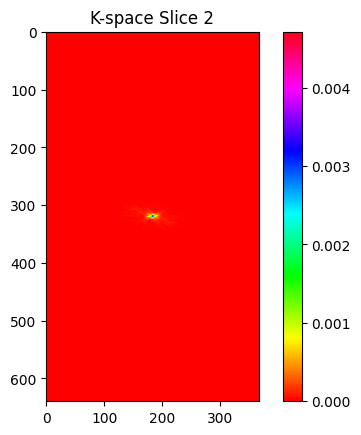

In [13]:
import matplotlib.pyplot as plt

# Assuming kspace is your 3D array representing k-space data
# Choose the index of the slice you want to visualize
slice_index = 2 # Change this to the index of the slice you want to visualize (15 in total)

# Extract the slice from the k-space data
slice_data = kspace[slice_index, :, :]

# Calculate the magnitude of the complex data
magnitude = np.abs(slice_data)


# Plot the slice using Matplotlib
plt.imshow(magnitude, cmap='hsv')#We can also use cmap="gray"
plt.title(f'K-space Slice {slice_index}')
plt.colorbar()
plt.show()


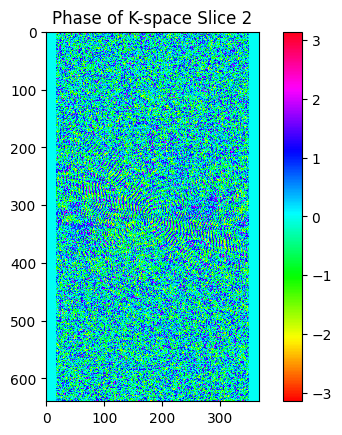

In [14]:
# Calculate the phase of the complex data
phase = np.angle(slice_data)

# Plot the phase using Matplotlib
plt.imshow(phase, cmap='hsv')  # Using 'hsv' colormap for better phase visualization
plt.title(f'Phase of K-space Slice {slice_index}')
plt.colorbar()
plt.show()


In [28]:
fname

'file1002570.h5'